In [1]:
from utils import str_to_datetime, print_current_step, parse_arguments, read_config

from searchdude import searchtc
from datadude import readfile
from datadude import writetc
from winddude import windmax

import datetime
import os

import time
import numpy as np
import skimage.feature

import netCDF4

In [2]:
ls

datadude.py             plottrack_exp.py*  tccat.py*               utils.py
do_one_member_jobs.sh*  plottrack.py*      tcstitch.py*            winddude.py
extra_scripts/          __pycache__/       tctrack.py*
n2o_config.py           README.md          temperature_edge.ipynb
plottrack_bycat.py*     searchdude.py      timeupdate.py


In [3]:
from extra_scripts.data_analysis.datareader import dataread
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

In [25]:
member = "01"
exp = "ref"
sim_base_dir = "/wolke_scratch/enzb/ICON/output/sim_13k_largedomain"

sim_params = dict(
    initime="2013-06-02T060000Z",
    endtime="2013-12-01T000000Z",
    member=member,
    exp=exp,
    indir="{sim_base_dir}/2013_{member}_{exp}/remap/".format(
        sim_base_dir=sim_base_dir, member=member, exp=exp
    ),
    indir2="{sim_base_dir}/2013_{member}_{exp}/remap/".format(
        sim_base_dir=sim_base_dir, member=member, exp=exp
    ),
    inbase="REMAP_NWP_LAM_DOM01_",
    inbase2="REMAP_NWP_LAM_PL_T_DOM01_",
    outname="TC_{member}_{exp}.txt".format(member=member, exp=exp),
    plot_members=["01"],  # ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10"]
)


tc_params = dict(
    slpdis=50000,  # minimum distance between two slp minima
    maxlat=45,  # maximum latitude that is considered in degrees
    vormin=1e-5,  # minimum vorticity to pass as TC
    temdif=1,  # temperature difference of warm core
    temdis=200000,  # distance at which location is considered "environment"
    winddis=100000,  # distance within which to look for wind maximum
    maxhgt=3000,  # maximum height where mind maximum is searched
    res=0.125,  # resolution in degrees
)
curr_datetime = str_to_datetime(sim_params["initime"])
end_datetime = str_to_datetime(sim_params["endtime"])

step = 0

In [26]:
tc_data = readfile(sim_params, curr_datetime)

attempting to read file /wolke_scratch/enzb/ICON/output/sim_13k_largedomain/2013_01_ref/remap/REMAP_NWP_LAM_DOM01_20130602T060000Z.nc
attempting to read file /wolke_scratch/enzb/ICON/output/sim_13k_largedomain/2013_01_ref/remap/REMAP_NWP_LAM_PL_T_DOM01_20130602T060000Z.nc


In [34]:
tc_data.keys()

dict_keys(['slp', 'vor', 'u', 'v', 'hgt', 'lon', 'lat', 'tem'])

In [31]:
x,y = mp(-118.75, 39.75,inverse=True)

In [199]:
def get_array_coordinates(x,y,lon, lat):
    i = np.where(lon == x)
    j = np.where(lat == y)
    try:
        i,j = int(i[0]), int(j[0])
        #print(i,j)
        return i,j
    except TypeError:
        raise "Coordinates not unique"

In [85]:
i,j = get_array_coordinates(-118.75, 39.75, tc_data["lon"], tc_data["lat"])

10 318


In [62]:
mpdeg = 2 * np.pi * 6371229 / 360
nind = round(tc_params["temdis"] / mpdeg * (1 / tc_params["res"]))
print("nind:  " + str(nind))
tem = tc_data["tem"]
np.ma.mean(tem[i - nind : i + nind, j - nind : j + nind]) + 1)

nind:  14


In [108]:
np.where()

(array([  0,   0,   0, ..., 560, 560, 560]),
 array([  0,   1,   2, ..., 838, 839, 840]))

In [119]:
(~(tem == np.ma.masked).data).any()

True

In [111]:
def msk(arr):
    i, j = get_array_coordinates(-118.75, 39.75, tc_data["lon"], tc_data["lat"])
    nind= 14
    #return arr[i - nind : i + nind, j - nind : j + nind]
    return arr[tem == np.ma.masked]

In [219]:
def msk2(arr):
    i, j = get_array_coordinates(-118.75, 39.75, tc_data["lon"], tc_data["lat"])
    nind= 14
    top = max(i-nind, 0)
    left = max(j-nind, 0)
    print(i,j)
    print(top, left)
    return arr[top: i + nind, left: j + nind]

0 304
0 304


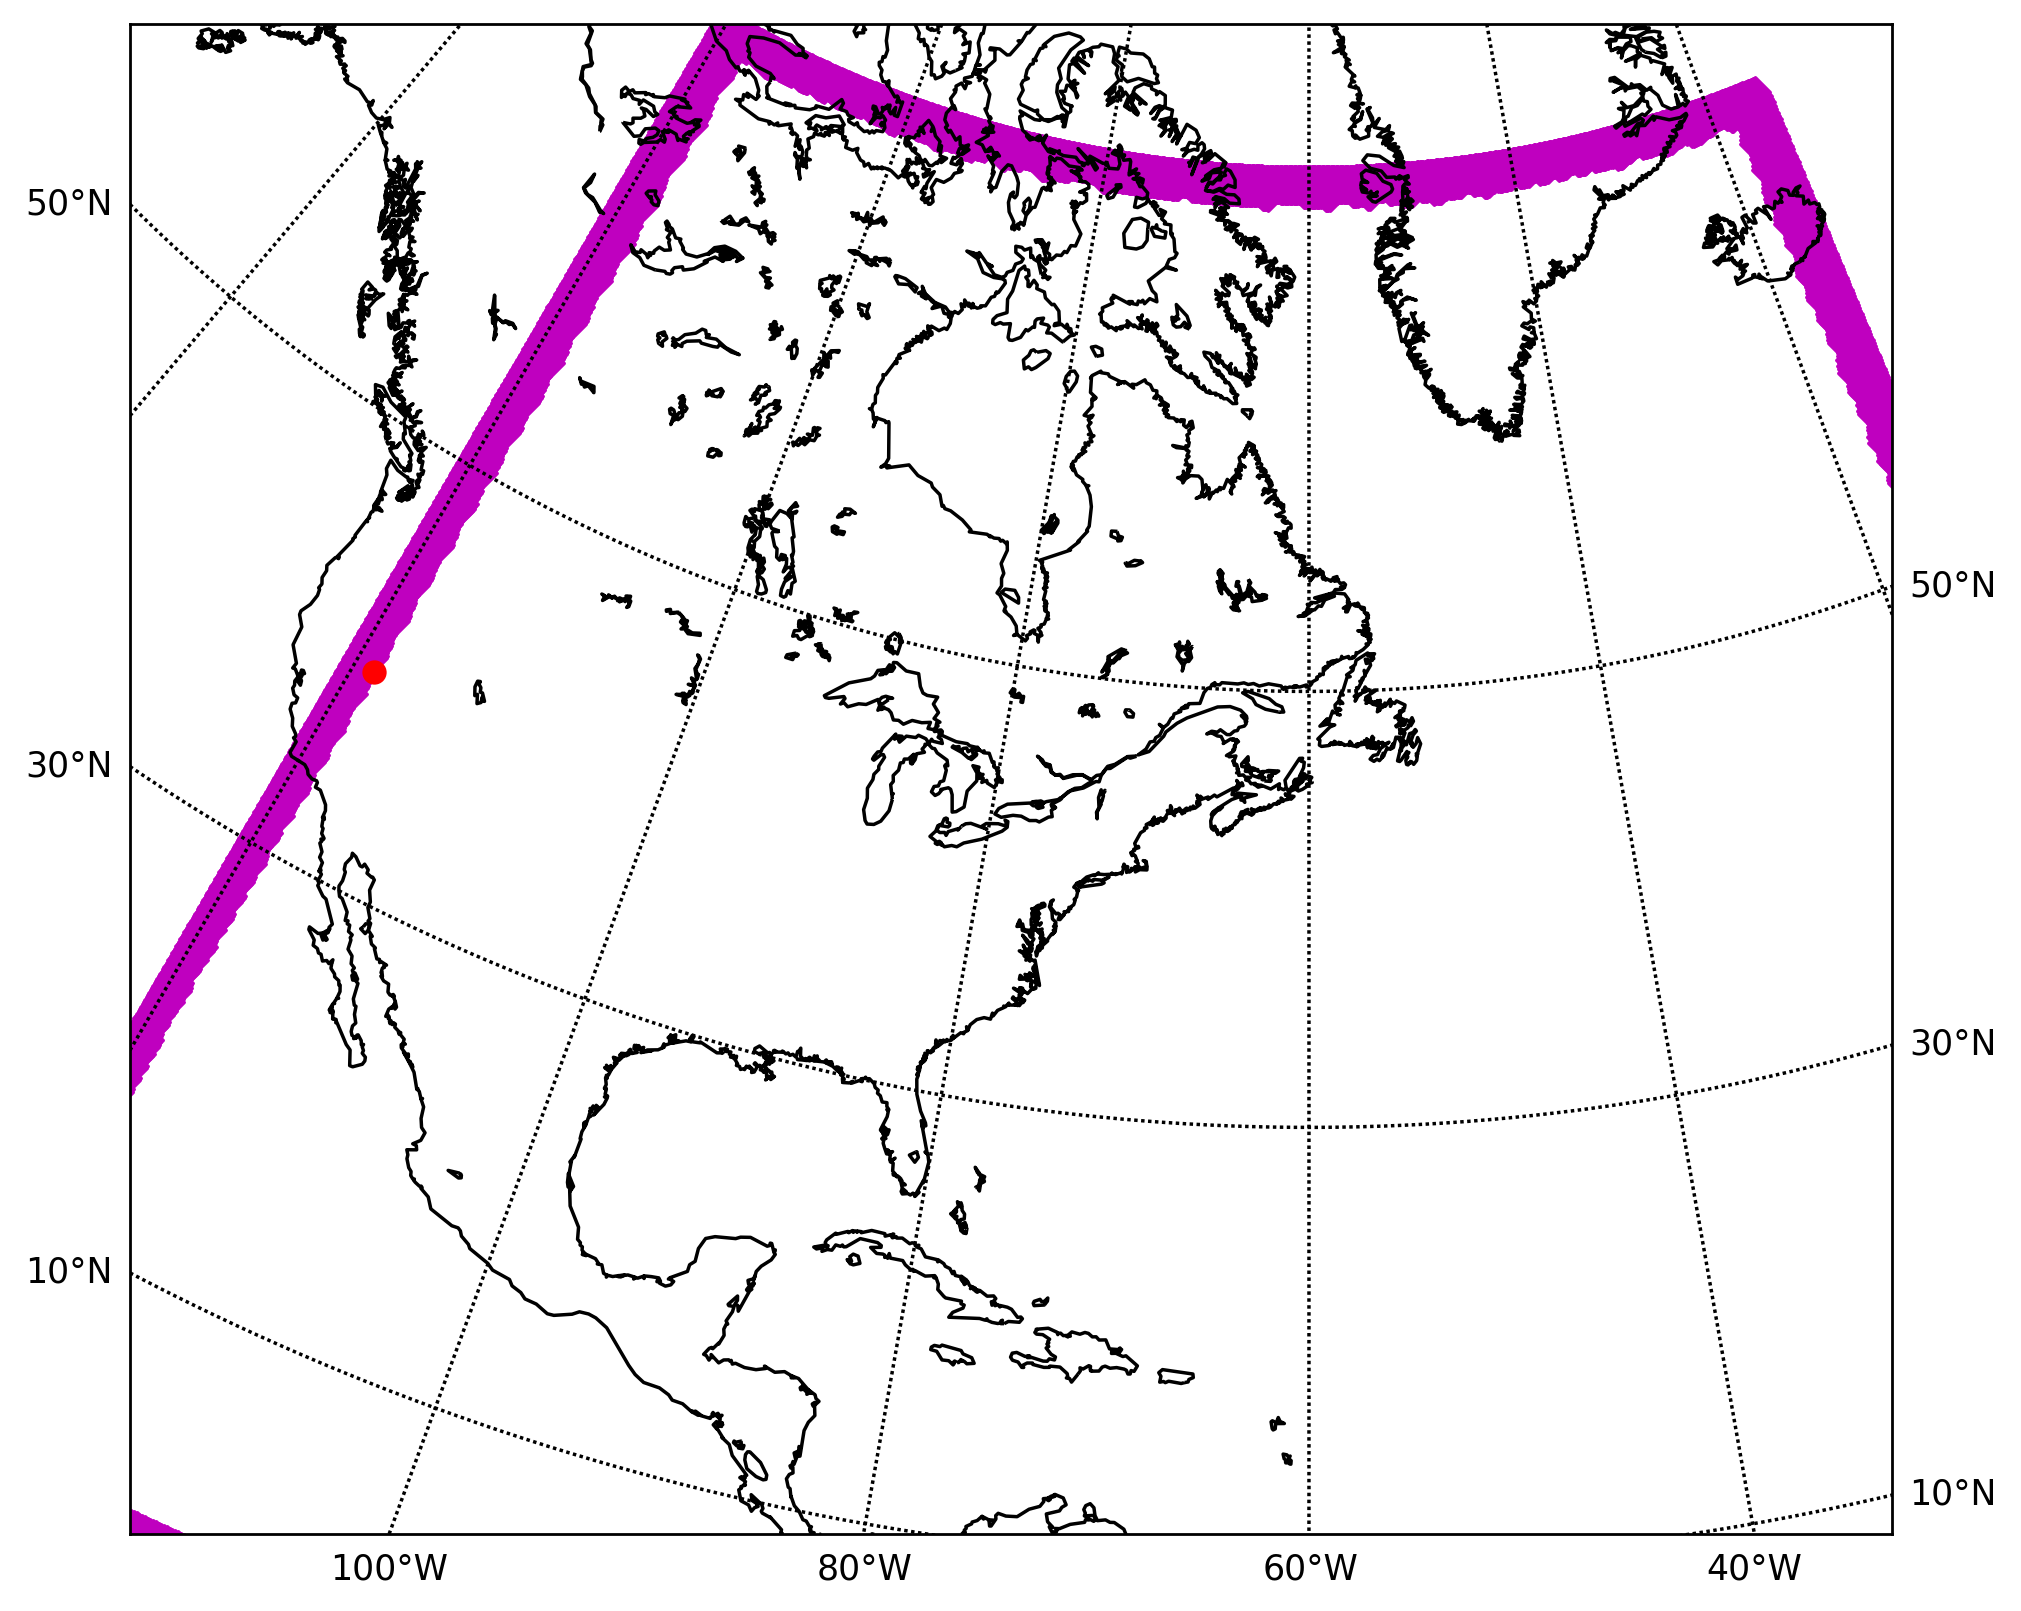

In [200]:
fig = plt.figure(figsize=(12,8),dpi=250)
data = tc_data["tem"]
#mp = Basemap(llcrnrlon=-120.,llcrnrlat=30.,urcrnrlon=-100.,urcrnrlat=50.,projection='lcc',lat_1=20.,lat_2=40.,lon_0=-60.,resolution='l',area_thresh=1000.)
mp = Basemap(llcrnrlon=-110.,llcrnrlat=0.,urcrnrlon=0.,urcrnrlat=70.,projection='lcc',lat_1=20.,lat_2=40.,lon_0=-60.,resolution='l',area_thresh=1000.)
mp.drawcoastlines()
mp.drawparallels(np.arange(10,70,20),labels=[1,1,0,0])
mp.drawmeridians(np.arange(-140,20,20),labels=[0,0,0,1])
xx, yy = np.meshgrid(tc_data["lon"], tc_data["lat"])
xx, yy = mp(xx,yy)
#mp.contourf(xx,yy,data,cmap='Blues')
x,y = mp(-118.75, 39.75)
mp.plot(x,y, "ro")

mp.scatter(msk(xx),msk(yy),marker='D',color='m')
mp.scatter(msk2(xx),msk2(yy),marker='D',color='g')
fig.show()

In [220]:
np.mean(msk2(tem))

10 318
0 304


241.9247085492228

In [221]:
tem[10,318]

242.07138

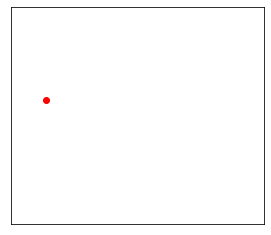

In [201]:
mp = Basemap(llcrnrlon=-110.,llcrnrlat=0.,urcrnrlon=0.,urcrnrlat=70.,projection='lcc',lat_1=20.,lat_2=40.,lon_0=-60.,resolution='l',area_thresh=1000.)
xx, yy = np.meshgrid(tc_data["lon"], tc_data["lat"])
xx, yy = mp(xx,yy)
x,y = mp(-118.75, 39.75)
mp.plot(x,y, "ro")

In [203]:
print(x,y)

1251338.925566665 4426266.193148953


In [205]:
msk2(xx).mean()

0 304


3557136.8235303937

In [211]:
msk2(yy).mean()

0 304


-947101.850792061

In [153]:
a[0:-1,0:8]

array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]])